In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from scipy import stats
import warnings
from TESStools import *

%matplotlib inline

In [2]:
short_cadence_xmatch = '../data/tess_gaia_magnitudes.csv'
#Note, this now does Sectors 1-7, but the selected stars are based on Sectors 1 & 2!!
data = pd.read_csv(short_cadence_xmatch)

In [3]:
#accounting for nonexistant A_G
nanmags = data[np.isnan(data['M_G'])]
nanmags['M_G_low'] = nanmags['phot_g_mean_mag'] - 5.0*np.log10(nanmags['r_est']) + 5
nanmags['BR_hi'] = nanmags['phot_bp_mean_mag']-nanmags['phot_rp_mean_mag']

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(-90, 90)

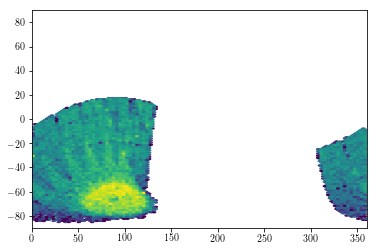

In [4]:
plt.hexbin(data['ra'],data['dec'],mincnt=1,bins='log')
plt.xlim(0,360)
plt.ylim(-90,90)

In [5]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

MWnames = ('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',
           'log_g','log_L','[Fe/H]_init','[Fe/H]','WISE_W1','WISE_W2','WISE_W3',
           'WISE_W4','phase')

Mfile = '../../GaiaSprintMassive/WISE/data/MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_massive = mist[(mist['initial_mass'] >= 8)]
mist_MS = mist[(mist['EEP'] >= 202)&(mist['EEP']<=454)]

#Now, in each color bin, give me the color and magnitude of the faintest star.
col_bins = np.linspace(-0.25,3,100)
min_cols = []
min_mags = []

for i,left in enumerate(col_bins[:-1]):
    mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                               (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
    min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
    if len(min_point) != 0:
        min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
        min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    minmag_dat = np.interp(data['(BP_RP)_0'], min_cols, min_mags)
    minmag_nan = np.interp(nanmags['BR_hi'], min_cols, min_mags)

    massive_dat = data[data['M_G'] <= minmag_dat]
    massive_nan = nanmags[nanmags['M_G_low'] <= minmag_nan]
    massive = pd.concat([massive_dat,massive_nan])
    massive.sort_values('phot_g_mean_mag',inplace=True)

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



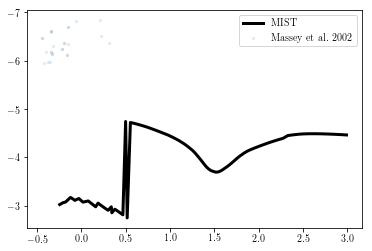

In [7]:
lmc_xmatch_file1 = '../data/massey02_gaiatess1-result.csv'
lmc_xmatch_file2 = '../data/massey02_gaiatess2-result.csv'

lmc_xmatch1 = pd.read_csv(lmc_xmatch_file1)
lmc_xmatch2 = pd.read_csv(lmc_xmatch_file2)

lmc_xmatch = pd.concat([lmc_xmatch1,lmc_xmatch2])

#Coefficients from Malhan, Ibata & Martin (2018a), ratio of A_X/A_V
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

lmc_RV = 3.41 #Gordon et al. 2003
lmc_EBV = 0.13 #Massey et al. 2007
lmc_EBPRP = (lmc_RV*lmc_EBV)*(ab_av-ar_av)
lmc_AG = (lmc_RV*lmc_EBV)*ag_av
lmc_xmatch['(BP_RP)_0'] = lmc_xmatch['phot_bp_mean_mag'] - lmc_xmatch['phot_rp_mean_mag'] - lmc_EBPRP
#distance modulus from Kovacs 2000
lmc_xmatch['M_G'] = lmc_xmatch['phot_g_mean_mag'] - 18.52 - lmc_AG #kovacs 2000
plt.scatter(lmc_xmatch['(BP_RP)_0'],lmc_xmatch['M_G'],s=5,alpha=0.1,label='Massey et al. 2002')
plt.plot(min_cols,min_mags,'-k',lw=3,label='MIST')
plt.gca().invert_yaxis()
plt.legend()

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    minmag = np.interp(lmc_xmatch['(BP_RP)_0'], min_cols, min_mags)

    lmc_massive = lmc_xmatch[lmc_xmatch['M_G'] <= minmag]
    lmc_massive.sort_values('phot_g_mean_mag',inplace=True)

In [9]:
massive = massive.append(lmc_massive, sort='phot_g_mean_mag')

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    customSimbad = Simbad()
    customSimbad.add_votable_fields('mk', 'otype', 'sptype')
    common_names = []
    mks = []
    otypes = []
    sptypes = []
    for i,row in massive.iterrows():
        coords = coord.SkyCoord(row['ra'],row['dec'],frame='icrs',unit=u.deg)
        result_table = customSimbad.query_region(coords, radius=2*u.arcsec)
        try:
            common_name = result_table['MAIN_ID'][0].decode('utf8')
            mk = result_table['MK_Spectral_type'][0].decode('utf8')
            otype = result_table['OTYPE'][0].decode('utf8')
            sptype = result_table['SP_TYPE'][0].decode('utf8')
            common_names.append(common_name)
            mks.append(mk)
            otypes.append(otype)
            sptypes.append(sptype)
        except TypeError:
            common_names.append(np.nan)
            mks.append(np.nan)
            otypes.append(np.nan)
            sptypes.append(np.nan)
    massive['CommonName'] = common_names
    massive['MKType'] = mks
    massive['SimbadOType'] = otypes
    massive['SpT'] = sptypes

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))

In [ ]:
np.savetxt('massive_ticids.txt',np.unique(massive['ticid']),fmt='%s')

In [ ]:
np.savetxt('unique_names.txt',np.unique(massive['CommonName']),fmt='%s')

In [ ]:
massive.to_csv('massive_2min.csv')

```python
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig = plt.figure(figsize=(20,100))
    
    data_dir = '../data/massive_lcs/'
    for i,ticid in enumerate(np.unique(massive['ticid'])):
        files = glob(data_dir+'*{}*'.format(ticid))
        lcs = []
        for f in files:
            lc = Table.read(f, format='fits')
            lcs.append(lc)
        outlc = vstack(lcs)
        plt.scatter(outlc['TIME'],0.01*i+outlc['PDCSAP_FLUX']/np.nanmedian(outlc['PDCSAP_FLUX']),alpha=0.5)
    plt.savefig('art.png')
    ```

In [ ]:
paper_tids = [179305185,404850274,279957111,389437365,389565293,40404470,29984014]

In [ ]:
fig = plt.figure(dpi=300)
plt.scatter(data['(BP_RP)_0'],data['M_G'],s=5,alpha=0.5,label='{\it Gaia}-TESS, $A_G$')
plt.scatter(nanmags['BR_hi'].values,nanmags['M_G_low'].values,s=5,alpha=0.1,label='{\it Gaia}-TESS, No $A_G$')
plt.scatter(lmc_xmatch['(BP_RP)_0'],lmc_xmatch['M_G'],s=5,alpha=0.5,label='{\it Gaia}-Massey et al. 2002')
plt.plot(min_cols,min_mags,'-k',lw=3,label='MIST cutoff')
#keep track of if we've done the label or not
red_flag = False
black_flag = False

for tid in np.unique(massive['ticid']):
    
    if (tid in paper_tids) or (tid in lmc_xmatch['ticid'].values):
        pass
    else:
        c = 'k'
        alpha = 0.3
        if not black_flag:
            label = 'Not Included'
            black_flag = True
        else:
            label = None

        row = massive.loc[massive['ticid'] == tid].iloc[0]
        if np.isnan(row['M_G_low']):
            plt.scatter(row['(BP_RP)_0'],row['M_G'],lw=1,marker='s',c='k',alpha=0.3,label=label)
        else:
            plt.scatter(row['BR_hi'],row['M_G_low'],lw=1,marker='s',c='k',alpha=0.3,label=label)
            
for tid in paper_tids:
    
    c = 'k'
    alpha = 0.3
    if not red_flag:
        label = 'This Study'
        red_flag = True
    else:
        label = None

    row = massive.loc[massive['ticid'] == tid].iloc[0]
    if np.isnan(row['M_G_low']):
        plt.scatter(row['(BP_RP)_0'],row['M_G'],lw=1,marker='s',c='none',edgecolors='r',alpha=1,label=label)
    else:
        plt.scatter(row['BR_hi'],row['M_G_low'],lw=1,marker='s',c='none',edgecolors='r',alpha=1,label=label)
    
plt.ylim(0,-7)
plt.legend(loc=4,framealpha=0.9)
plt.xlabel('$G_{BP} - G_{RP}$',fontsize=18)
plt.ylabel('$M_G$',fontsize=18)
plt.savefig('../plots/CMD.pdf')

In [ ]:
paper_types = ['LBV','YSG',r'Ofpe/WN9$\rightarrow$LBV','YSG','YSG','YSG','YSG']
nplots = len(paper_tids)
fig, axes = plt.subplots(nplots, figsize=(6,10), dpi=300, sharex=True)
for i,tid in enumerate(paper_tids):
    fname = np.unique(massive['CommonName'][massive['ticid']==tid])[0].replace('*','').replace('V','')
    lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
    
    foo = lc[['Time','Flux']]
    foo.to_csv('{0}.csv'.format(fname),index=False)
    
    ax = axes[i]
    ax.scatter(lc['Time'],lc['Flux'],s=1,c='k',alpha=0.3,label='Data')
    ax.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C1',label='Rolling Median')
    ax.set(xlim=(np.min(lc['Time'])-1,np.max(lc['Time'])+1), ylim=(0.999*np.min(lc['Flux']),1.001*np.max(lc['Flux'])),title=fname+' ({0})'.format(paper_types[i]))
    h, l = ax.get_legend_handles_labels()

axes[2].legend(handles = h[::-1], labels = l[::-1])
labax = fig.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
labax.set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX')
labax.set_zorder(-1)
fig.tight_layout()

labax.xaxis.label.set_size(18)
labax.yaxis.label.set_size(18)
for tick in labax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in labax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.savefig('../plots/all_lcs.pdf')

In [ ]:
np.savetxt('paper_ticids.txt',paper_tids,fmt='%s')